# Traitement des corrélations dans une pipeline de modélisation

Dans le fichier `correlation.py`, 3 méthodes de sélection de variables à partir des corrélations sont implémentées. Ces 3 méthodes sont implémentés au travers de l'interface `TransformerMixin` de `sklearn` pour pouvoir être intégrée facilement dans des pipelines.

1. Corrélation avec la variable cible (`CorrelationToTarget`) : on garde uniquement les variables qui sont corrélées avec la variable à prédire. Le seuil de corrélation est un paramètre de ce transformer.
2. Détection des corrélations par paires (`PairwiseCorrelationDrop`) : quand une variable est corrélée (seuil de corrélation en paramètre), on retire cette variable de notre sélection. Par symétrie, on devrait retirer les deux variables en questions, le choix qui est fait est de retirer celle qui est en moyenne la plus corrélée avec les autres variables. Cette méthode est expliquée [ici](https://towardsdatascience.com/are-you-dropping-too-many-correlated-features-d1c96654abe6) et étendue pour éviter de retirer trop de colonnes. L'extension repose sur le fait que l'on retire itérativement les variables corrélées pour éviter de les prendre en compte lorsque l'on s'intéresse aux variables suivantes.
3. Regroupement de variables en fonction de leurs corrélations (`ClusteringCorrelation`) : les variables sont regroupés par une CAH en prenant comme distance $1-abs(corr(X_i, X_j))$. Les groupes sont déterminés par un seuil de corrélation, toutes les variables dans un groupe sont corrélées à plus de $1 - seuil$. La méthode est détaillée [ici](https://kobia.fr/automatiser-la-reduction-des-correlations-par-clustering/). Pour chaque groupe, 2 possibilités : on garde un nombre de colonnes fixé à l'avance (1 par défaut), on construit une PCA pour chaque groupe et on choisit le nombre de composantes à garder.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import set_config

from sklearn.datasets import load_diabetes
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

from cc_tk.feature.correlation import (
    CorrelationToTarget,
    # ClusteringCorrelation,
    # PairwiseCorrelationDrop,
)

In [2]:
set_config(transform_output="pandas")

In [3]:
X, y = load_diabetes(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

In [4]:
X.columns

Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'], dtype='object')

In [5]:
baseline = DummyRegressor()
baseline.fit(X_train, y_train)
baseline.score(X_test, y_test)

-0.0003801753238461547

## Corrélation avec la cible

In [6]:
correlation_target_pipeline = make_pipeline(
    MinMaxScaler().set_output(transform="pandas"),
    CorrelationToTarget(threshold=0.1),
    LinearRegression(),
)
correlation_target_pipeline.fit(X_train, y_train)
correlation_target_pipeline.score(X_test, y_test)

0.48613757778290967

In [7]:
correlation_target_pipeline["correlationtotarget"]._selected_columns

Index(['age', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'], dtype='object')

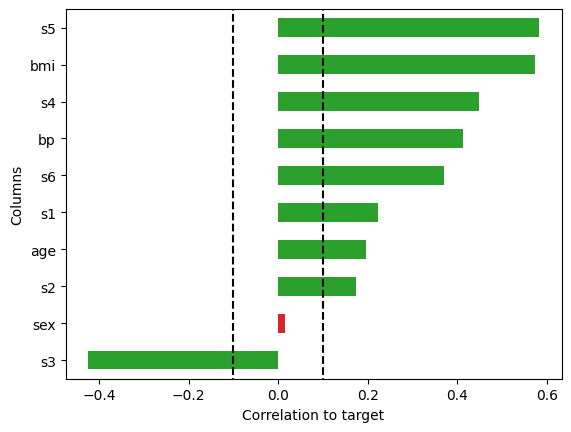

In [8]:
correlation_target_pipeline["correlationtotarget"].plot_correlation()

## Corrélation par pair

In [7]:
correlation_pairwise_pipeline = make_pipeline(
    MinMaxScaler().set_output(transform="pandas"),
    PairwiseCorrelationDrop(threshold=0.8),
    LinearRegression(),
)
correlation_pairwise_pipeline.fit(X_train, y_train)
correlation_pairwise_pipeline.score(X_test, y_test)

c:\Users\u1138000\OneDrive - IQVIA\Documents\Projets\correlated-data\correlation.py:264: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(s, ignore_index = True)


0.4838338289064399

In [8]:
correlation_pairwise_pipeline["pairwisecorrelationdrop"].columns_to_keep

['age', 'sex', 'bmi', 'bp', 's2', 's3', 's4', 's5', 's6']

## Clusters de corrélation

In [32]:
correlation_clustering_pipeline = make_pipeline(
    MinMaxScaler().set_output(transform="pandas"),
    ClusteringCorrelation(threshold=0.3, summary_method="first"),
    LinearRegression(),
)
correlation_clustering_pipeline.fit(X_train, y_train)
correlation_clustering_pipeline.score(X_test, y_test)

0.4850187399809789

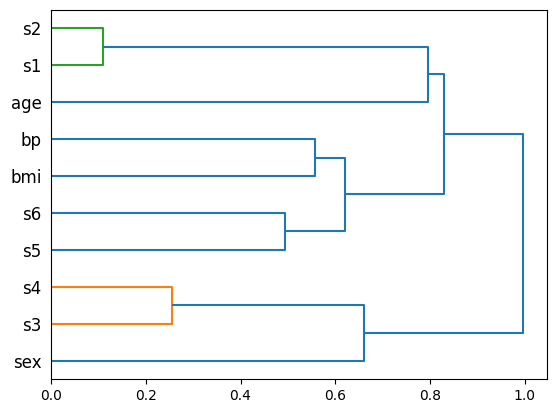

In [33]:
dendro = correlation_clustering_pipeline["clusteringcorrelation"].plot_dendro()

## Combinaison de différents transformer

Il est aussi possible de combiner différentes méthodes de sélection de variables.

In [34]:
correlation_combined_pipeline = make_pipeline(
    MinMaxScaler().set_output(transform="pandas"),
    CorrelationToTarget(threshold=0.1),
    ClusteringCorrelation(threshold=0.3, summary_method="first"),
    LinearRegression(),
)
correlation_combined_pipeline.fit(X_train, y_train)
correlation_combined_pipeline.score(X_test, y_test)

0.4636990163174318